### Algorithm 1
##### Initial version

In [1]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import tensorly as tl
from sktensor.tucker import hooi
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()

In [83]:
#reading data
mat = scipy.io.loadmat('azip.mat')
A = mat['azip'] #matrix 265 x 1707, one column is one digit
mat = scipy.io.loadmat('dzip.mat')
D = mat['dzip'] #matrix 1 x 1707, info about A

k = np.unique(D).size #broj klastera, broj jedinstvenih elementa u D -> ovo zbog općenitosti 


In [81]:
#p = 0

for i in range (k):
    A_ = A[:, np.where(D == i)[1]] #daje podmatricu od A čiji stupci odgovaraju točno jednoj znamenci
    T = tl.vec_to_tensor(A_,(16,16,A_.shape[1])) #konstruira tenzor reda 16x16xbroj pojavljivanja te znamenke
    #p += T.shape[2] ovo treba biti 1707, provjera, ovo je ok 
    
    #sad trebam napraviti HOSVD nad tim tenzorom
    

In [82]:
T.shape

(16, 16, 132)

## Algoritam 2

In [85]:
## data manipulating
T_main = np.zeros((16,16,1707))

for i in range((A.shape[1])): #za svaki stupac od A
    T_main[:,:,i] = np.reshape(A[:, i], (16,16)) 
    
T_main.shape #veliki ne sistematičan

(16, 16, 1707)

In [95]:
def sort_tensor(T, D): #T is tensor, D is correct output for slices
    
    T_solution = np.empty((16,16,1707))
    
    for i in range(k):
        if(i == 0):
            T_solution[:,:,0: len(np.where(D == i)[1])] = T_main[:,:,np.where(D == i)[1]]
        else:
            T_solution[:,:,len(np.where(D == (i-1))[1]) : len(np.where(D == (i-1))[1]) + len(np.where(D == i)[1])] = T_main[:,:,np.where(D == i)[1]]
    
    return(T_solution)

#ovo provjeriti jel još okej

In [99]:
#konstrukcija jednog velikog tenzora
T_sort = sort_tensor(T_main, D)

for i in range((A.shape[1])): #za svaki stupac od A
    T_main[:,:,i] = np.reshape(A[:, i], (16,16)) #frontalni odsječak je jedna znamenka
    
#hosvd od glavnog tenzora
#Y = hooi(T, [16, 16, 256], init='nvecs') ovo radi baš sa tenzorima
#istražiti sintaksu!
U1, S1, V1 = np.linalg.svd(tl.unfold(T_main, 0), full_matrices=False) #16x16
U2, S2, V2 = np.linalg.svd(tl.unfold(T_main, 1), full_matrices=False) #16x16
U3, S3, V3 = np.linalg.svd(tl.unfold(T_main, 2), full_matrices=False) #1707 x 256

S_ = tl.tenalg.mode_dot(T_main,np.transpose(U1),mode=0,transpose=False)
S__ = tl.tenalg.mode_dot(S_,np.transpose(U2),mode=1,transpose=False)
S = tl.tenalg.mode_dot(S__,np.transpose(U3),mode=2,transpose=False) #16x16x256

In [62]:
U1, S1, V1 = np.linalg.svd(tl.unfold(T_main, 0), full_matrices=False) #16x16
U2, S2, V2 = np.linalg.svd(tl.unfold(T_main, 1), full_matrices=False) #16x16
U3, S3, V3 = np.linalg.svd(tl.unfold(T_main, 2), full_matrices=False) #1707x256

S_ = tl.tenalg.mode_dot(T_main,np.transpose(U1),mode=0,transpose=False)
S__ = tl.tenalg.mode_dot(S_,np.transpose(U2),mode=1,transpose=False)
S = tl.tenalg.mode_dot(S__,np.transpose(U3),mode=2,transpose=False) #16x16x256

#optimalnije, provjereno da daje isto 
#S = tl.tenalg.multi_mode_dot(T_main, [np.transpose(U1),np.transpose(U2),np.transpose(U3)], modes = [0,1,2], transpose=False)

In [100]:
def plot_norm(T):
    
    norm_1 = np.zeros(T.shape[0]) 
    for i in range(T.shape[0]):
        norm_1[i] = np.linalg.norm(T[i,:,:]) ** 2 #optimizirati naknadno: suma dij!

    norm_2 = np.zeros(T.shape[1])   
    for i in range(T.shape[1]):
        norm_2[i] = np.linalg.norm(T[:,i,:]) ** 2

    norm_3 = np.zeros(T.shape[2])   
    for i in range(T.shape[2]):
        norm_3[i] = np.linalg.norm(T[:,:,i]) ** 2

    df_ = pd.DataFrame(data = {'Mode 1':norm_1, 'Mode 2':norm_2}) #opt isto
    df__ = pd.DataFrame(data = {'Mode 3':norm_3})
    df = pd.concat([df_,df__], ignore_index=True, axis=1)

    sns.lineplot(data = df)
    

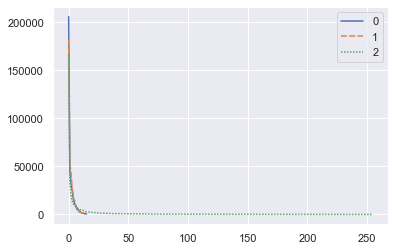

In [101]:
plot_norm(S) #kak ovdje doć do cijelog tenzora a ne samo ovog reduciranog?
#do reduciranog dođem ako odrežem U3? 

In [ ]:
#dobivanje matrica B
#recimo da imam jezgreni tenzor
